# Team as an entity model

This model is a

In [1]:
# Import
from torch import nn
from torch.utils.data import DataLoader

from models.models import *
from datasets.datasets import *
from utils import *

c:\Users\thgla\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Meta
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(f"Device: {device}")

Device: cuda


# Dataset

In [3]:
dataset = get_player_dataset(NL=[1,2,3,4,5])

reading file
Loaded 13794 rows.
Normalizing features
['GP', 'G', 'A', 'PTS', 'PS', 'EV', 'PP', 'S']
Loading player data
creating dataset structure
creating player dict


# Dataloader

In [49]:
batch_size = 100

N_datasets = dataset.random_split(0.1)

N_datasets_train = []
N_datasets_test = []
N_dataloaders_train = []   
N_dataloaders_test = []
all_datasets_train = []
all_datasets_test = []

for (N, train_dataset, test_dataset) in N_datasets:
    N_datasets_train.append(PlayerDataset(train_dataset, max_N=N))
    N_datasets_test.append(PlayerDataset(test_dataset, max_N=N))
    
    all_datasets_train += train_dataset
    all_datasets_test +=test_dataset

    print(f"Train size for {N} seasons: {len(N_datasets_train[-1])}")
    print(f"Test size for {N} seasons: {len(N_datasets_test[-1])}")

    N_dataloaders_train.append(DataLoader(N_datasets_train[-1], batch_size=batch_size, shuffle=True))
    N_dataloaders_test.append(DataLoader(N_datasets_test[-1], batch_size=batch_size, shuffle=True))

all_datasets_train = PlayerDataset(all_datasets_train, max_N=5)
all_datasets_test = PlayerDataset(all_datasets_test, max_N=5)
print(f"Train size for all seasons: {len(all_datasets_train)}")
print(f"Test size for all seasons: {len(all_datasets_test)}")

all_dataloader_train = DataLoader(all_datasets_train, batch_size=batch_size, shuffle=True)
all_dataloader_test = DataLoader(all_datasets_test, batch_size=batch_size, shuffle=True)

print(N_datasets_train[0].__getitem__(0))

Train size for 1 seasons: 8983
Test size for 1 seasons: 1061
Train size for 2 seasons: 6851
Test size for 2 seasons: 817
Train size for 3 seasons: 5312
Test size for 3 seasons: 633
Train size for 4 seasons: 4137
Test size for 4 seasons: 493
Train size for 5 seasons: 3208
Test size for 5 seasons: 382
Train size for all seasons: 28491
Test size for all seasons: 3386
(tensor([[ 0.4304, -0.1871, -0.0886, -0.0875, -1.0616, -0.3073, -0.7603,  0.1264]]), tensor([ 0.2186, -0.4411, -0.7833, -0.6070, -1.7050, -0.3073, -0.7603, -0.0800]))


# Training and Validation

In [50]:
hidden_size = 8
MLP_hidden_size = 8
num_layers = 1
lr = 0.001
epochs = 50
loss_interval = 5

model_N = []
model_N_losses = []


for i in range(5):
    print(f"Training model for {i+1} seasons")
    input_size = len(N_datasets_train[i].__getitem__(0)[0][0])
    model_N.append(PlayerStandalone(input_size=input_size, hidden_size=hidden_size, MLP_hidden_size=MLP_hidden_size, num_layers=num_layers, device=device).to(device))
    criterion = RMSELoss()
    optimizer = torch.optim.Adam(model_N[i].parameters(), lr=lr)
    
    (model_N[i], train_losses,val_losses) = train_and_validate(model_N[i], criterion, optimizer, N_dataloaders_train[i], N_dataloaders_test[i], epochs=epochs, loss_interval=loss_interval, device=device)
    model_N_losses.append((train_losses, val_losses))
    
    
    
# Train on all data
print("Training model for all seasons")
input_size = len(all_datasets_train.__getitem__(0)[0][0])
model_all = PlayerStandalone(input_size=input_size, hidden_size=hidden_size, MLP_hidden_size=MLP_hidden_size, num_layers=num_layers, device=device).to(device)
criterion = RMSELoss()
optimizer = torch.optim.Adam(model_all.parameters(), lr=lr)
(model_all, train_losses,val_losses) = train_and_validate(model_all, criterion, optimizer, all_dataloader_train, all_dataloader_test, epochs=epochs, loss_interval=loss_interval, device=device)

model_all_losses = (train_losses, val_losses)






Training model for 1 seasons
0 th epoch :  0.9590465353594886
Validation loss for epoch 0: 0.9173900539224799
Validation loss for epoch 5: 0.7136197306893088
10 th epoch :  0.6639538811312782
Validation loss for epoch 10: 0.6942650459029458
Validation loss for epoch 15: 0.691040429201993
20 th epoch :  0.6583639846907722
Validation loss for epoch 20: 0.6899569197134539
Validation loss for epoch 25: 0.6900545575402
30 th epoch :  0.6573030915525224
Validation loss for epoch 30: 0.6886638565496965
Validation loss for epoch 35: 0.689984841780229
40 th epoch :  0.6562718855010139
Validation loss for epoch 40: 0.6880242716182362
Validation loss for epoch 45: 0.6896877613934603
Training model for 2 seasons
0 th epoch :  0.9146033344061478
Validation loss for epoch 0: 0.8746698829862807
Validation loss for epoch 5: 0.6887706584400601
10 th epoch :  0.6433894064115442
Validation loss for epoch 10: 0.6579332616594102
Validation loss for epoch 15: 0.6419478687975142
20 th epoch :  0.629947187244

In [51]:
lr = 0.001
epochs = 40
loss_interval = 5

model_linear_N = []
model_linear_N_losses = []


for i in range(5):
    print(f"Training model for {i+1} seasons")
    input_size = len(N_datasets_train[i].__getitem__(0)[0][0])
    model_linear_N.append(PlayerLinear(input_size=input_size, N=i+1, device=device).to(device))
    criterion = RMSELoss()
    optimizer = torch.optim.Adam(model_linear_N[i].parameters(), lr=lr)
    
    (model_linear_N[i], train_losses,val_losses) = train_and_validate(model_linear_N[i], criterion, optimizer, N_dataloaders_train[i], N_dataloaders_test[i], epochs=epochs, loss_interval=loss_interval, device=device)
    model_linear_N_losses.append((train_losses, val_losses))

# Train on all data
print("Training model for all seasons")
input_size = len(all_datasets_train.__getitem__(0)[0][0])
model_linear_all = PlayerLinear(input_size=input_size, N=5, device=device).to(device)
criterion = RMSELoss()
optimizer = torch.optim.Adam(model_linear_all.parameters(), lr=lr)
(model_linear_all, train_losses,val_losses) = train_and_validate(model_linear_all, criterion, optimizer, all_dataloader_train, all_dataloader_test, epochs=epochs, loss_interval=loss_interval, device=device)

model_linear_all_losses = (train_losses, val_losses)

Training model for 1 seasons
0 th epoch :  0.9334662841426001
Validation loss for epoch 0: 0.8455213633450595
Validation loss for epoch 5: 0.725441959771243
10 th epoch :  0.6769958873589833
Validation loss for epoch 10: 0.7063860459761186
Validation loss for epoch 15: 0.6999390558762983
20 th epoch :  0.6680375039577484
Validation loss for epoch 20: 0.6944236538626931
Validation loss for epoch 25: 0.6967794028195468
30 th epoch :  0.6671742690934075
Validation loss for epoch 30: 0.694127001545646
Validation loss for epoch 35: 0.6944165392355486
Training model for 2 seasons
0 th epoch :  0.8689470869907434
Validation loss for epoch 0: 0.7706391678916084
Validation loss for epoch 5: 0.6725007891654968
10 th epoch :  0.6405383443486863
Validation loss for epoch 10: 0.6719135244687399
Validation loss for epoch 15: 0.6561920841534933
20 th epoch :  0.6350586500720702
Validation loss for epoch 20: 0.6478383209970262
Validation loss for epoch 25: 0.6691809561517503
30 th epoch :  0.634548499

In [52]:
#average results baseline
criterion = RMSELoss()
avg_loss_N = []

for i in range(5):
    avg_pred = []
    avg_target = []
    for (x, y) in N_datasets_train[i]:
        avg_pred.append(torch.mean(x, dim=0))
        avg_target.append(y)
    avg_pred = torch.stack(avg_pred)
    avg_target = torch.stack(avg_target)
    avg_loss_N.append(criterion(avg_pred, avg_target))
    

In [53]:
#evaluate model trained on all N for individual N
criterion = RMSELoss()
model_all_losses_N = []
for i in range(5):
    avg_pred = []
    avg_target = []
    for (x, y) in N_datasets_train[i]:
        pred = model_all(x.unsqueeze(0).to(device))[0]
        avg_pred.append(pred.cpu().detach())
        avg_target.append(y)
    avg_pred = torch.stack(avg_pred)
    avg_target = torch.stack(avg_target)
    train_loss = criterion(avg_pred, avg_target)
    
    avg_pred = []
    avg_target = []
    for (x, y) in N_datasets_test[i]:
        pred = model_all(x.unsqueeze(0).to(device))[0]
        avg_pred.append(pred.cpu().detach())
        avg_target.append(y)
    avg_pred = torch.stack(avg_pred)
    avg_target = torch.stack(avg_target)
    test_loss = criterion(avg_pred, avg_target)
    model_all_losses_N.append((train_loss, test_loss))

In [54]:
 
model_linear_all_losses_N = []
for i in range(5):
    avg_pred = []
    avg_target = []
    for (x, y) in N_datasets_train[i]:
        #pad
        pads = [torch.zeros_like(x[0]) for _ in range(4-i)]
        #use pre-padding
        if i != 4:
            padded_x = torch.cat((torch.stack(pads), x), dim=0)
        else:
            padded_x = x
        
        pred = model_linear_all(padded_x.unsqueeze(0).to(device))[0]
        avg_pred.append(pred.cpu().detach())
        avg_target.append(y)
    avg_pred = torch.stack(avg_pred)
    avg_target = torch.stack(avg_target)
    train_loss = criterion(avg_pred, avg_target)
    
    avg_pred = []
    avg_target = []
    for (x, y) in N_datasets_test[i]:
        #pad
        pads = [torch.zeros_like(x[0]) for _ in range(4-i)]
        #use pre-padding
        if i != 4:
            padded_x = torch.cat((torch.stack(pads), x), dim=0)
        else:
            padded_x = x
        pred = model_linear_all(padded_x.unsqueeze(0).to(device))[0]
        avg_pred.append(pred.cpu().detach())
        avg_target.append(y)
    avg_pred = torch.stack(avg_pred)
    avg_target = torch.stack(avg_target)
    test_loss = criterion(avg_pred, avg_target)
    model_linear_all_losses_N.append((train_loss, test_loss))

# Plot Results

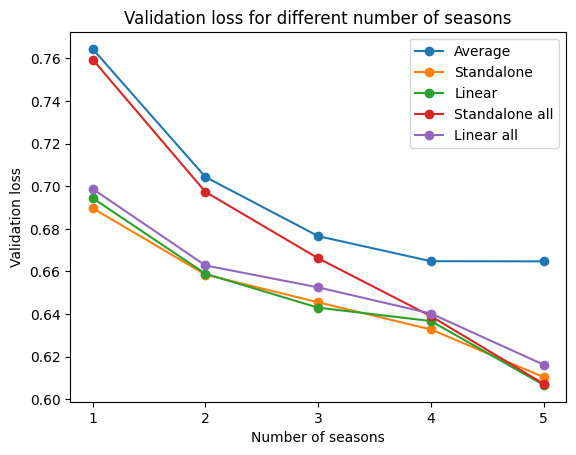

In [55]:
#plot seaons on x-axis and final validation loss on y-axis
plt.title('Validation loss for different number of seasons')
plt.plot(range(1,6), avg_loss_N, label='Average',marker='o')
plt.plot(range(1,6), [model_N_losses[i][1][-1] for i in range(5)], label='Standalone',marker='o')
plt.plot(range(1,6), [model_linear_N_losses[i][1][-1] for i in range(5)], label='Linear',marker='o')
plt.plot(range(1,6), [model_all_losses_N[i][1] for i in range(5)], label='Standalone all',marker='o')
plt.plot(range(1,6), [model_linear_all_losses_N[i][1] for i in range(5)], label='Linear all',marker='o')
plt.xlabel('Number of seasons')
plt.ylabel('Validation loss')
plt.xticks(range(1,6))
plt.legend()

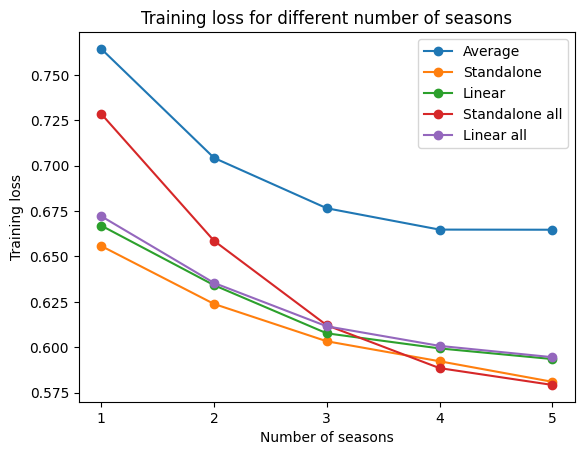

In [56]:
plt.title('Training loss for different number of seasons')
plt.plot(range(1,6), avg_loss_N, label='Average',marker='o')
plt.plot(range(1,6), [model_N_losses[i][0][-1] for i in range(5)], label='Standalone',marker='o')
plt.plot(range(1,6), [model_linear_N_losses[i][0][-1] for i in range(5)], label='Linear',marker='o')
plt.plot(range(1,6), [model_all_losses_N[i][0] for i in range(5)], label='Standalone all',marker='o')
plt.plot(range(1,6), [model_linear_all_losses_N[i][0] for i in range(5)], label='Linear all',marker='o')
plt.xlabel('Number of seasons')
plt.ylabel('Training loss')
plt.xticks(range(1,6))
plt.legend()


In [116]:
# Define loss
def Ind_RMSELoss(yhat, y):
    return torch.sqrt(torch.mean((yhat-y)**2,axis=0))

In [117]:
avg_loss_ind = Ind_RMSELoss(avg_predictions, avg_targets)
print(f"Average loss individual: {avg_loss_ind}")

sample =dataset_train.__getitem__(0)
print(sample[1])
print(dataset.unnormalize(sample[1]))


pred_sample = model(sample[0].unsqueeze(0).to(device))
print(dataset.unnormalize(pred_sample.cpu().detach()))

pred_sample_linear = model_linear(sample[0].unsqueeze(0).to(device))
print(dataset.unnormalize(pred_sample_linear.cpu().detach()))

Average loss individual: tensor([0.7399, 0.6320, 0.6093, 0.5829, 0.7378, 0.6639, 0.7719, 0.5420])
tensor([-0.1345, -0.4411, -0.3645, -0.3548,  0.0365, -0.7037, -0.7603, -0.1584])
tensor([44.0000,  2.0000,  4.0000,  6.0000,  1.9000,  1.0000,  0.0000, 32.0000])
tensor([[62.9642,  1.7425,  8.5793, 12.4374,  2.7494,  1.4527,  0.1728, 55.8191]])
tensor([[58.5362,  1.7094,  8.0973,  8.7693,  2.7860,  1.2783,  0.1737, 38.3846]])


# Exploration results

Exploration 

In [118]:
test_preds = []
test_targets = []
test_avg_baseline = []
test_avg_baseline_linear = []



for step, (x,y) in enumerate(dataset_test): 
    pred = model(x.unsqueeze(0).to(device))[0]
    test_preds.append(pred.cpu().detach())
    test_targets.append(y)
    pred_linear = model_linear(x.unsqueeze(0).to(device))[0]
    test_avg_baseline_linear.append(pred_linear.cpu().detach())
    #drop all padded zeros
    x = x[x.sum(dim=1) != 0]
    test_avg_baseline.append(torch.mean(x, dim=0))

    
    
#stack all the tensors
test_preds = torch.stack(test_preds)
test_targets = torch.stack(test_targets)
test_avg_baseline = torch.stack(test_avg_baseline)
test_avg_baseline_linear = torch.stack(test_avg_baseline_linear)


    
preds_n_targets = (test_targets, test_preds, test_avg_baseline, test_avg_baseline_linear)

#unnormalize
preds_n_targets = (dataset.unnormalize(preds_n_targets[0]), dataset.unnormalize(preds_n_targets[1]), dataset.unnormalize(preds_n_targets[2]), dataset.unnormalize(preds_n_targets[3]))


In [119]:
print(preds_n_targets[3].shape)

torch.Size([332, 8])


In [120]:
def plot_correlation(pred_n_targets_dict, criterion, stat_names):
    """
    Plots the divergence between the predictions and the targets. It includes the max positive and negative deviations.

    NL: list of the N values used for targets/preds
    pred_n_targets_dict: dictionary where each entry is an N from NL and contains the list of all target/prediction pairs
    criterion: loss function object

    NOTE: NL, targets and preds must all have the same size
    """

    
    y, y_hat, y_base, y_base_avg = pred_n_targets_dict

    for stat_idx in range(len(y[0])):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
        fig.suptitle(f'Predictions for stat: {stat_names[stat_idx]}', fontsize=18)

        #add axis labels
        ax1.set_xlabel("Target")
        ax1.set_ylabel("Prediction")
        ax2.set_xlabel("Target")
        ax2.set_ylabel("Prediction")

        target_stats = y[:, stat_idx]
        preds_stats = y_hat[:, stat_idx]
        baseline_stats = y_base_avg[:, stat_idx]
        
        
        ax1.scatter(target_stats, preds_stats, c="b",s=10)
        ax1.plot(target_stats,target_stats)

       

        # Basline linear
        ax2.scatter(target_stats, baseline_stats, c="b",s=10)
        ax2.plot(target_stats,target_stats)
        
        #annotate with the loss
        loss_per_feature = criterion(preds_stats, target_stats)
        loss_per_feature_base = criterion(baseline_stats, target_stats)
        ax1.annotate(f"Loss: {round(loss_per_feature.item(),4)}", xy=(0.5, 0.1), xycoords='axes fraction')
        ax2.annotate(f"Loss: {round(loss_per_feature_base.item(),4)}", xy=(0.5, 0.1), xycoords='axes fraction')

        
        ax1.grid()
        ax2.grid()
        
        plt.show()

<BarContainer object of 8 artists>

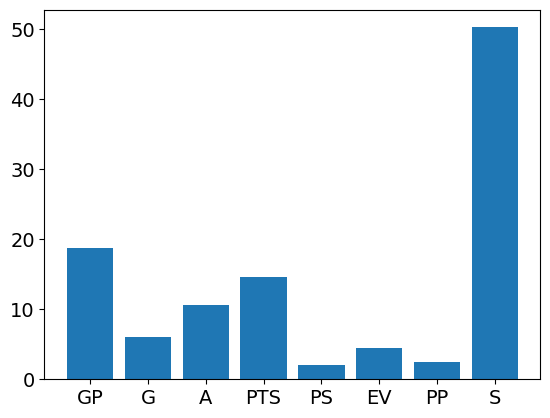

In [121]:
#loss per feature
loss_per_feature = Ind_RMSELoss(preds_n_targets[0], preds_n_targets[1])

plt.bar(dataset.col_names,loss_per_feature)

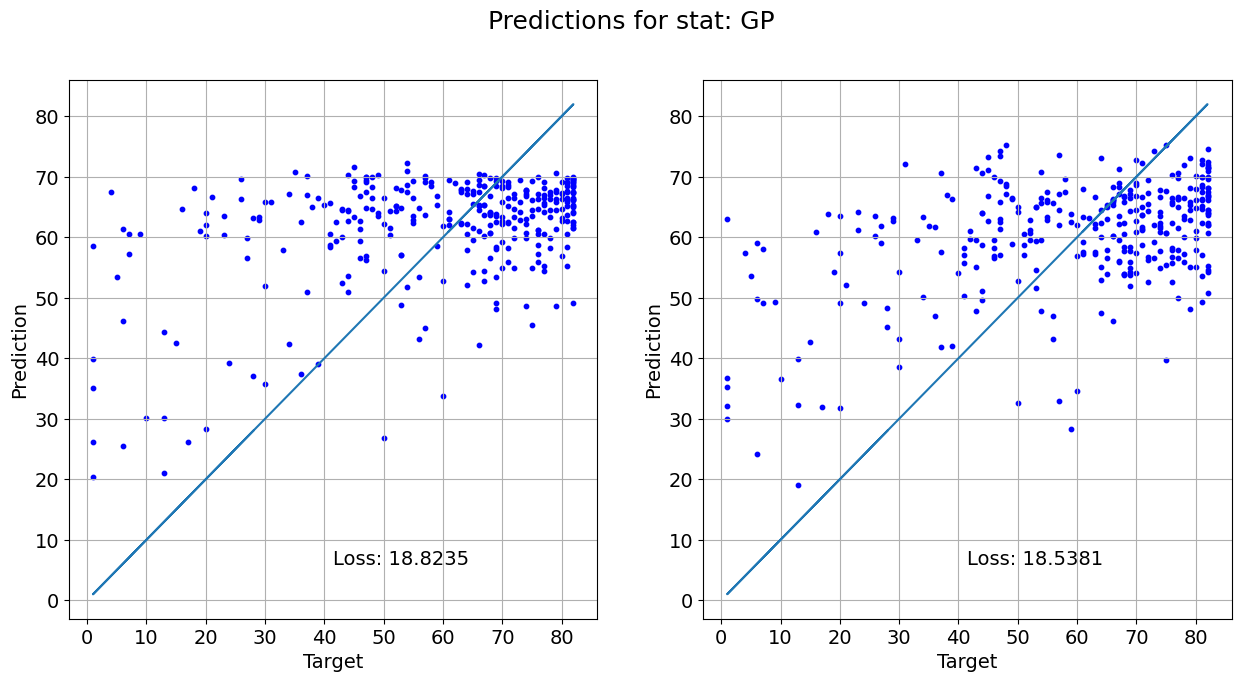

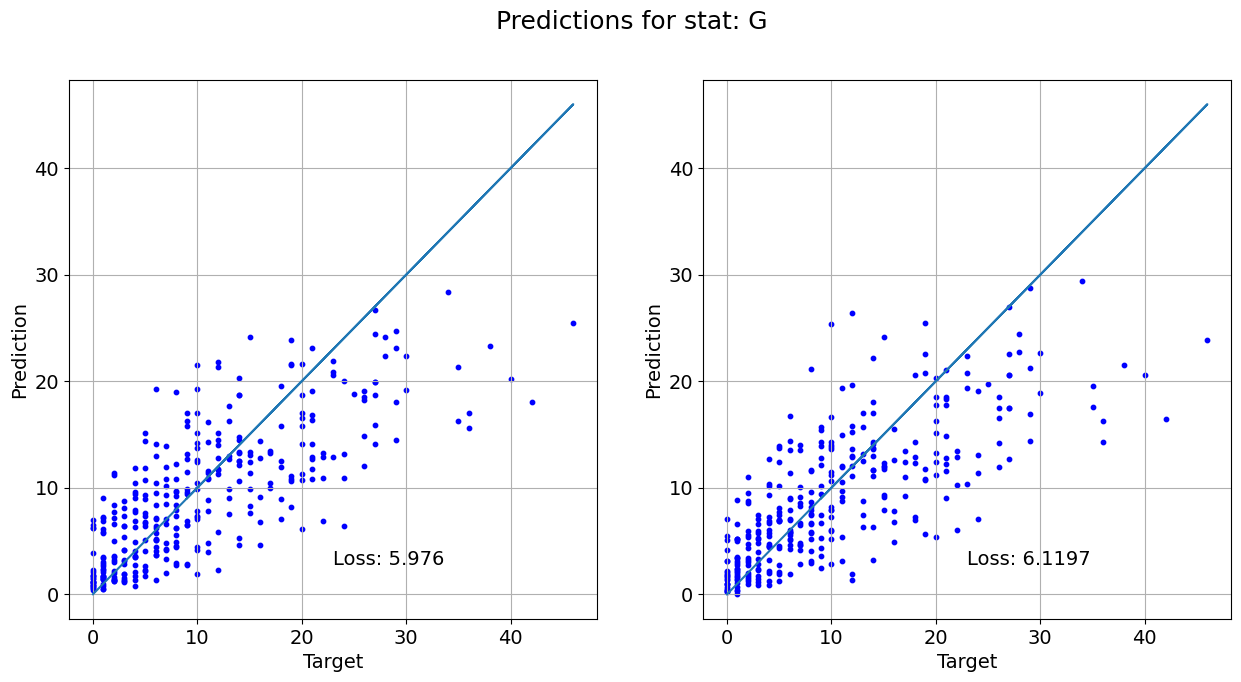

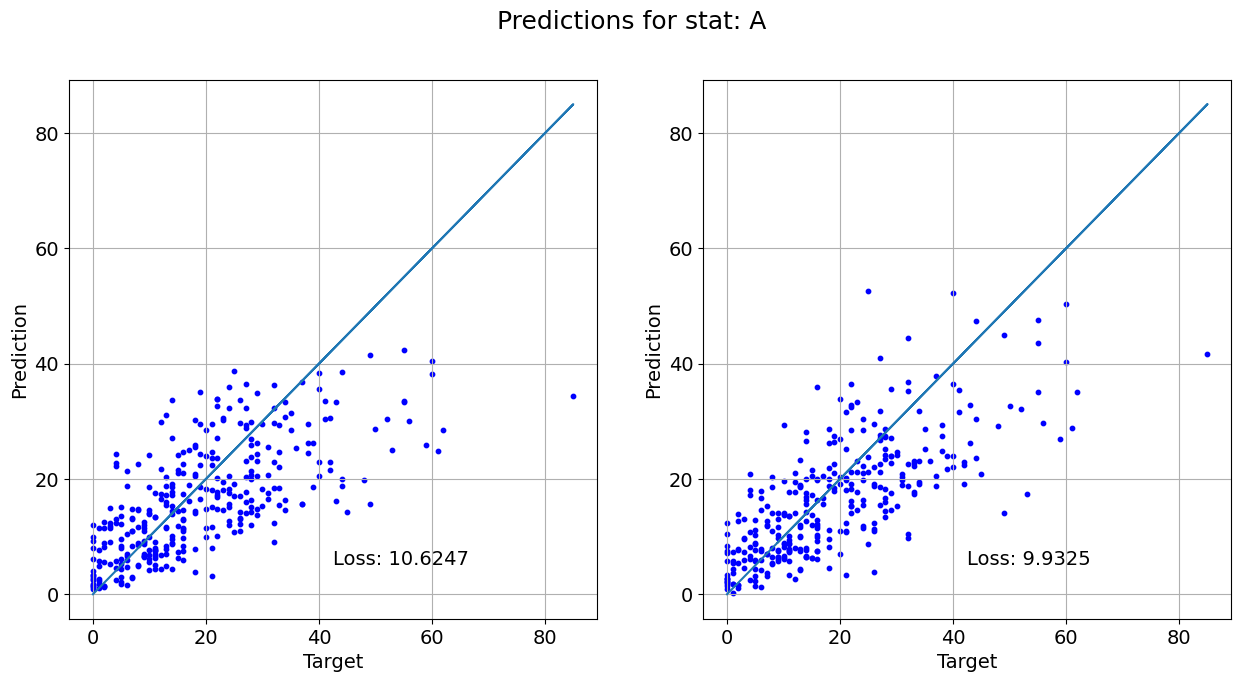

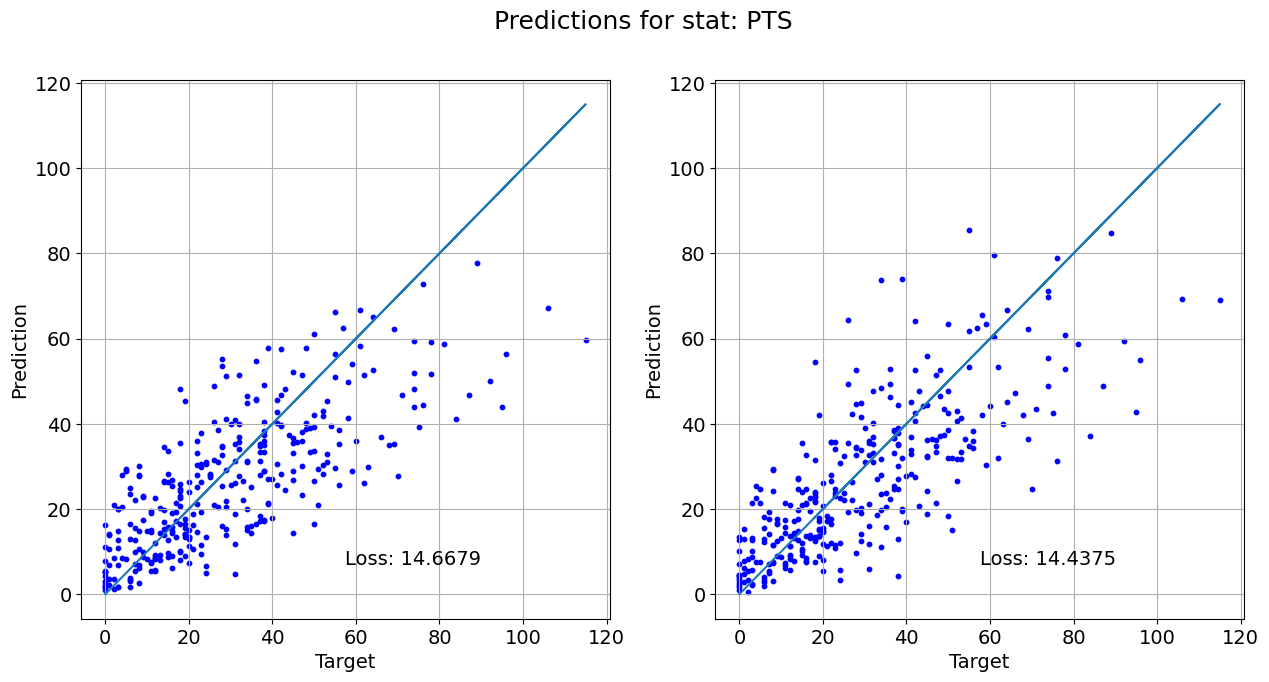

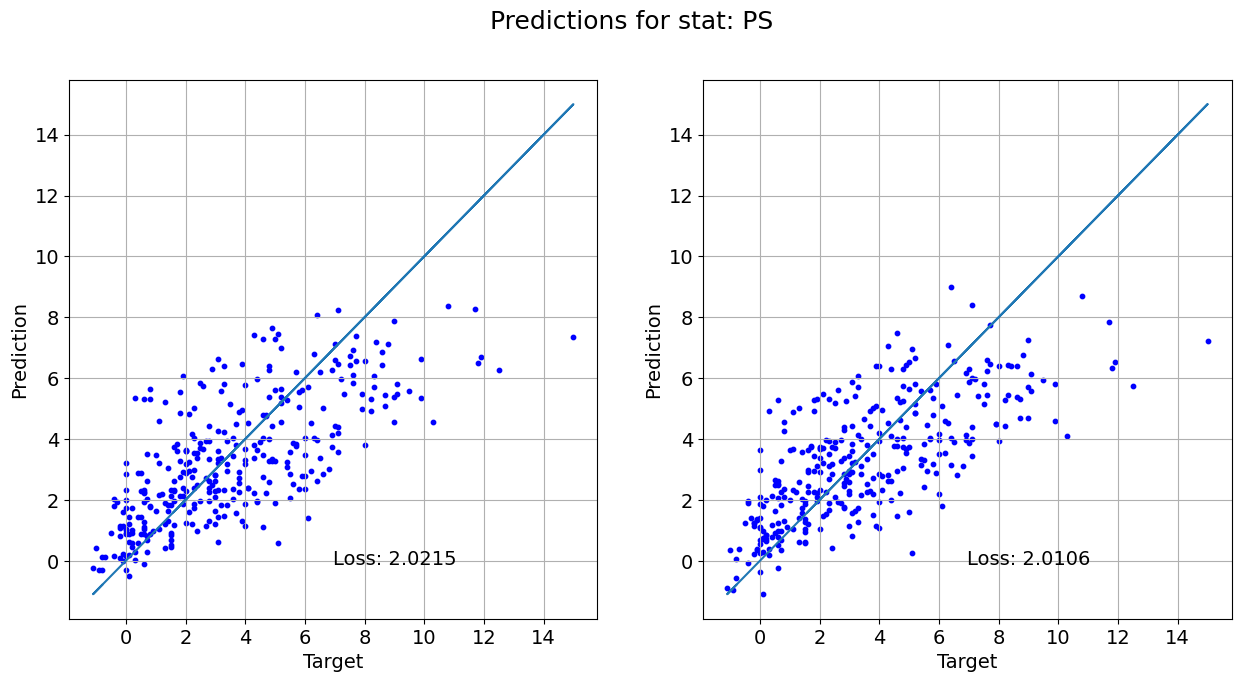

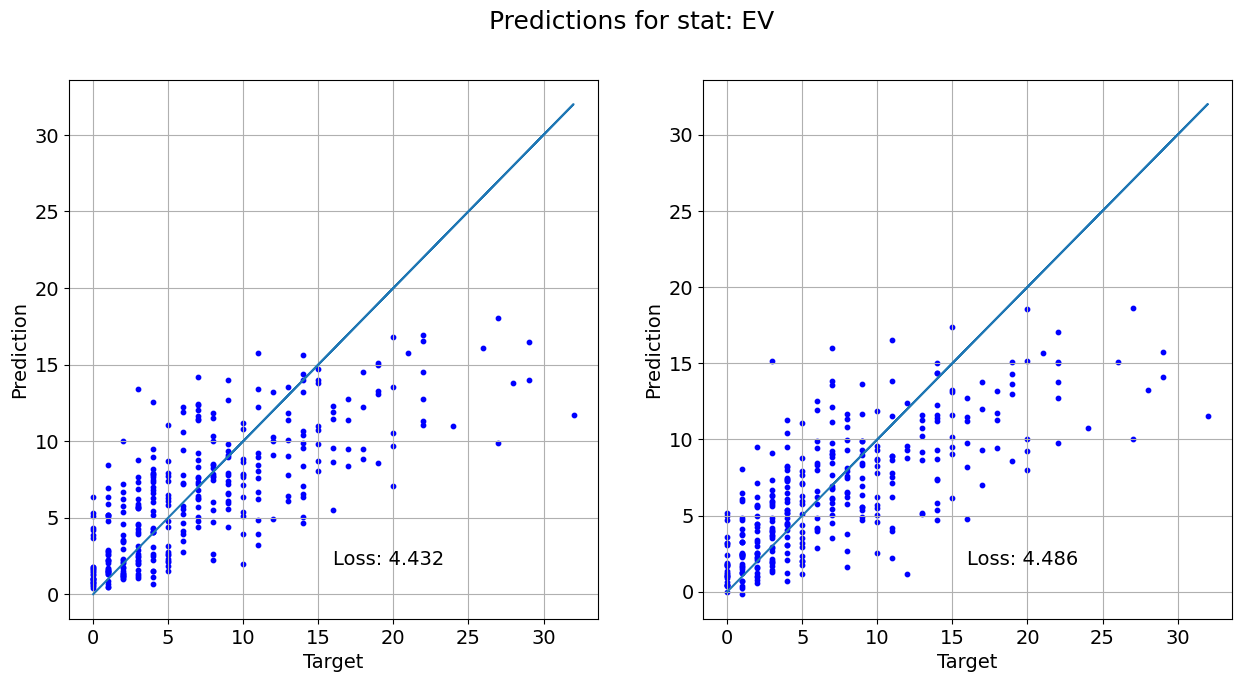

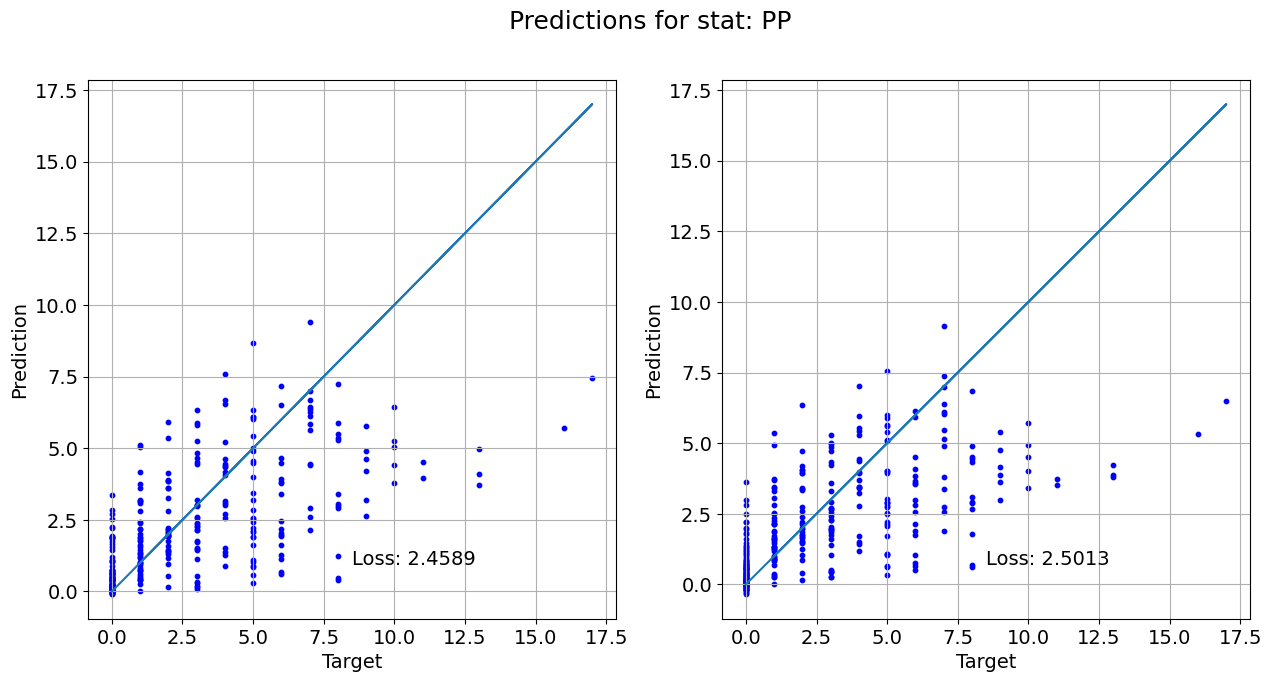

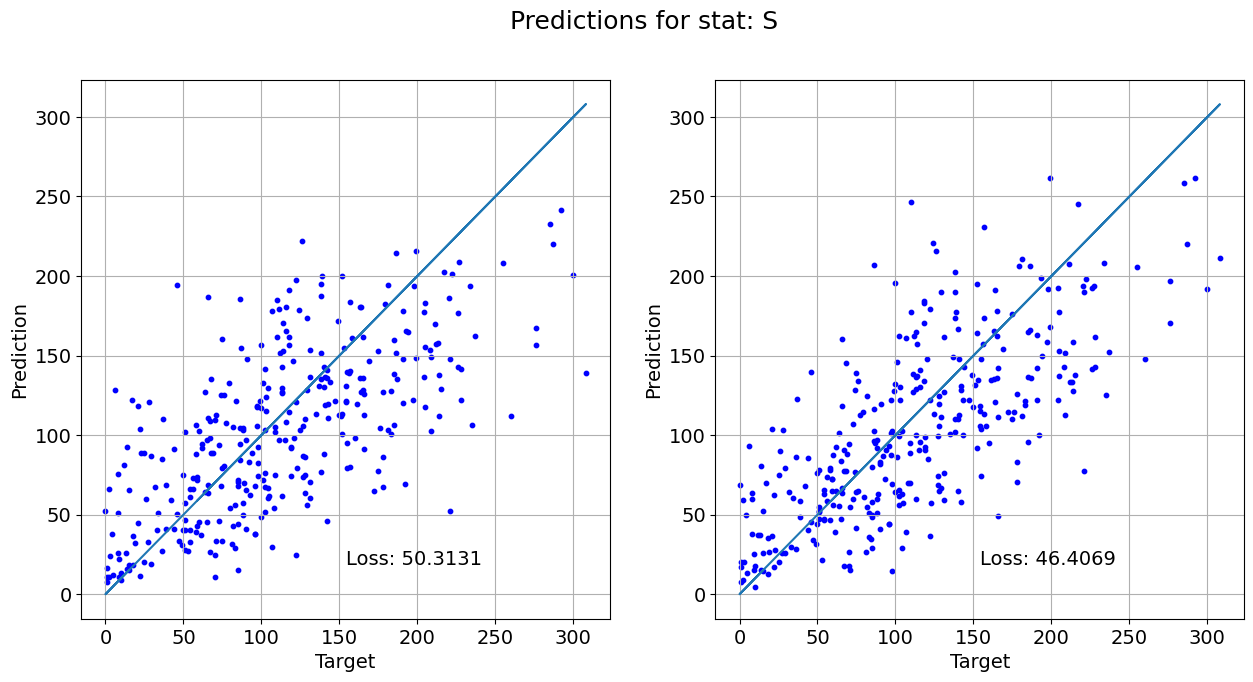

In [122]:
plot_correlation(preds_n_targets, criterion, stat_names=dataset.col_names)

In [128]:
series = []
for step, (x,y) in enumerate(dataset_train):
    plus_minus = torch.cat((x,y.unsqueeze(0)), dim=0)
    series.append(plus_minus[:,5])

avgs = torch.stack(series).mean()

diff = [series[i] - avgs for i in range(len(series))]

print(torch.stack(diff).mean(dim=0))

    

tensor([ 0.0186,  0.0169, -0.0004, -0.0351])
